Reference: https://cran.r-project.org/web/packages/rstan/vignettes/rstan.html

In [1]:
import stan
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio; nest_asyncio.apply()
import pandas as pd; pd.set_option("mode.chained_assignment", None)
from utils import select_columns, plot_ESS, plot_GR, plot_posterior

num_chains = 20
num_samples = 2000
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])
data = {"J": len(y), "y": y, "sigma": sigma}

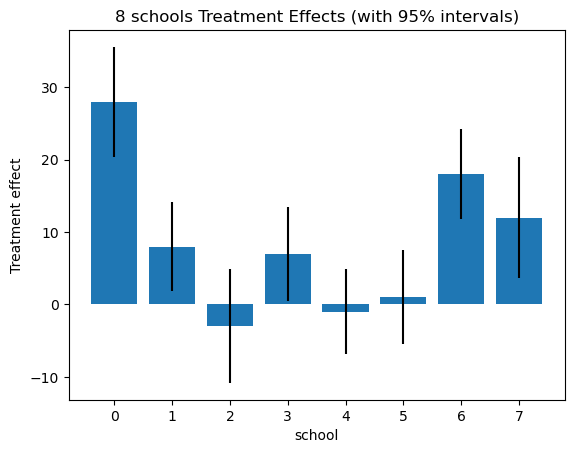

In [2]:
plt.bar(np.arange(0, len(y)), y, color="tab:blue", yerr=1.96 * (sigma ** 0.5))
plt.title("8 schools Treatment Effects (with 95% intervals)")
plt.ylabel("Treatment effect")
plt.xlabel("school")
plt.show()

In [10]:
eight_school_centered = """
data {
  int<lower=0> J;                   // number of schools
  array[J] real y;                  // estimated treatment effects
  array[J] real<lower=0> sigma;     // standard error of effect estimates
}
parameters {
  real mu;                          // population treatment effect
  real<lower=0> tau;                // standard deviation in treatment effects
  vector[J] theta;                  // school treatment effects
}
model {
  mu ~ normal(0, 5);
  tau ~ lognormal(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);         // likelihood
}
"""

posterior_centered = stan.build(eight_school_centered, data=data)
fit_centered = posterior_centered.sample(num_chains=num_chains, num_samples=num_samples)
df_centered = fit_centered.to_frame()
df_centered.to_csv("result/eight_school_centered.csv")

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (3000/60000)
Sampling:  10% (6000/60000)
Sampling:  15% (9000/60000)
Sampling:  20% (12000/60000)
Sampling:  25% (15000/60000)
Sampling:  30% (18000/60000)
Sampling:  35% (21000/60000)
Sampling:  40% (24000/60000)
Sampling:  45% (27000/60000)
Sampling:  50% (30000/60000)
Sampling:  55% (33000/60000)
Sampling:  60% (36000/60000)
Sampling:  65% (39000/60000)
Sampling:  70% (42000/60000)
Sampling:  75% (45000/60000)
Sampling:  80% (48000/60000)
Sampling:  85% (51000/60000)
Sampling:  90% (54000/60000)
Sampling:  95% (57000/60000)
Sampling: 100% (60000/60000)
Sampling: 100% (60000/60000), done.
Messages received during sampling:
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your

In [17]:
eight_school_noncentered = """
data {
  int<lower=0> J;                   // number of schools
  array[J] real y;                  // estimated treatment effects
  array[J] real<lower=0> sigma;     // standard error of effect estimates
}
parameters {
  real mu_hat;                      // reparameterised mu
  real tau_hat;                     // reparameterised tau
  vector[J] theta_hat;              // reparameterised theta
}
transformed parameters {
  real mu = mu_hat * 5;
  real<lower=0> tau = exp(tau_hat * 5);
  vector[J] theta = mu + theta_hat * tau;
}
model {
  mu_hat ~ normal(0, 1);
  tau_hat ~ normal(0, 1);
  theta_hat ~ normal(0, 1);
  y ~ normal(theta, sigma);   // likelihood
}
"""

posterior_noncentered = stan.build(eight_school_noncentered, data=data)
fit_noncentered = posterior_noncentered.sample(num_chains=num_chains, num_samples=num_samples)
df_noncentered = fit_noncentered.to_frame()
df_noncentered.to_csv("result/eight_school_noncentered.csv")

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (3000/60000)
Sampling:  10% (6000/60000)
Sampling:  15% (9000/60000)
Sampling:  20% (12000/60000)
Sampling:  25% (15000/60000)
Sampling:  30% (18000/60000)
Sampling:  35% (21000/60000)
Sampling:  40% (24000/60000)
Sampling:  45% (27000/60000)
Sampling:  50% (30000/60000)
Sampling:  55% (33000/60000)
Sampling:  60% (36000/60000)
Sampling:  65% (39000/60000)
Sampling:  70% (42000/60000)
Sampling:  75% (45000/60000)
Sampling:  80% (48000/60000)
Sampling:  85% (51000/60000)
Sampling:  90% (54000/60000)
Sampling:  95% (57000/60000)
Sampling: 100% (60000/60000)
Sampling: 100% (60000/60000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your

In [3]:
df_centered = pd.read_csv("result/eight_school_centered.csv")
df_noncentered = pd.read_csv("result/eight_school_noncentered.csv")
dfs = [df_centered, df_noncentered]
labels = ["centered", "noncentered"]

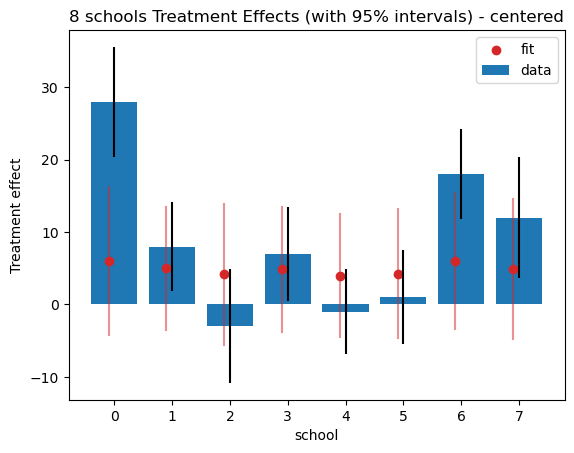

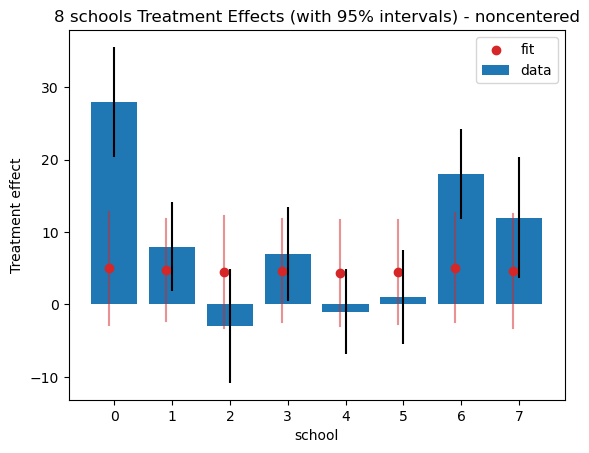

In [4]:
for df, label in zip(dfs, labels):
    mean = select_columns(df, "theta.").to_numpy().mean(axis=0)
    std = select_columns(df, "theta.").to_numpy().std(axis=0)
    plt.bar(np.arange(0, len(y)), y, color="tab:blue", yerr=1.96 * (sigma ** 0.5), label="data")
    plt.scatter(np.arange(0, len(y)) - 0.1, mean, color="tab:red", label="fit")
    for i, (ymin, ymax) in enumerate(zip(mean - 1.96 * std, mean + 1.96 * std)):
        plt.plot([i - 0.1, i - 0.1], [ymin, ymax], color="tab:red", alpha=0.5)
    plt.title(f"8 schools Treatment Effects (with 95% intervals) - {label}")
    plt.ylabel("Treatment effect")
    plt.xlabel("school")
    plt.legend()
    plt.show()

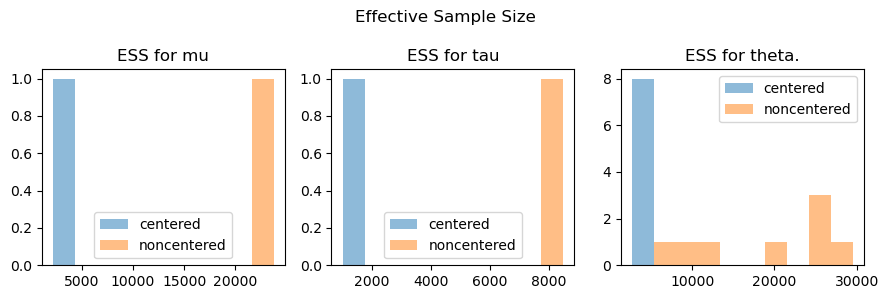

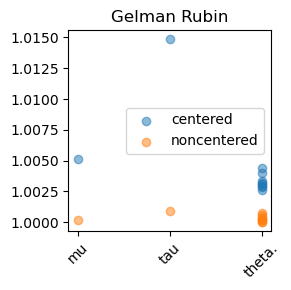

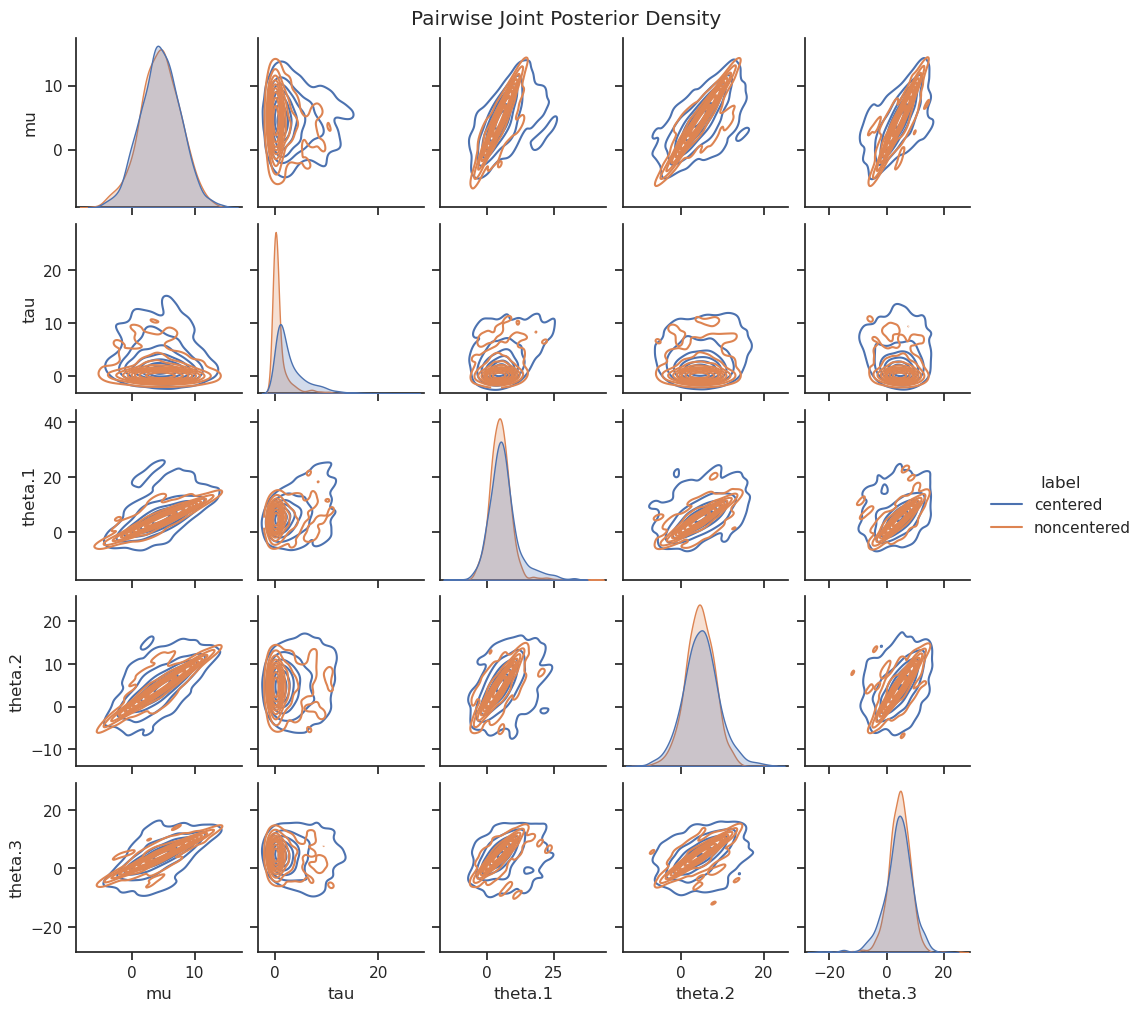

In [9]:
plot_ESS(dfs, labels,
         params=["mu", "tau", "theta."],
         num_chains=num_chains, num_samples=num_samples)

plot_GR(dfs, labels,
        params=["mu", "tau", "theta."],
        num_chains=num_chains, num_samples=num_samples)

plot_posterior(dfs, labels,
               params=["mu", "tau", "theta.1", "theta.2", "theta.3"],
               num_subsamples=1000)